## Versie 1: Dinsdag om 9.00

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy

# Standaardisatie functie uit utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def read_and_preprocess_data(path):
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    print("Data after loading:\n", data.head())  # Print first few rows to inspect

    data.columns = pd.to_datetime(data.columns, format='%d/%m/%Y')
    print("Data with datetime columns:\n", data.head())  # Print first few rows to inspect
    print("Data loaded with shape:", data.shape)

    return data

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements
        print("Shape of X before transpose:", X.shape)
        print("Shape of Y before transpose:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            raise ValueError("The number of columns in X and Y must be the same")

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"

df_data = read_and_preprocess_data(FILE_PATH)

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

print("Y_train_other shape:", Y_train_other.shape)
print("Y_reg_train shape:", Y_reg_train.shape)

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

print("Y_train_other_std shape:", Y_train_other_std.shape)
print("Y_reg_train_std shape:", Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Data after loading:
                31/01/1995  28/02/1995  31/03/1995  30/04/1995  31/05/1995  \
CPI_Australia    0.024124    0.028044    0.031274    0.034579    0.036988   
CPI_Canada       0.002320    0.013954    0.018562    0.020858    0.026637   
CPI_Denmark      0.021439    0.018790    0.021865    0.020748    0.019117   
CPI_Germany      0.019024    0.015133    0.018857    0.017588    0.016301   
CPI_Japan        0.006263    0.006263   -0.002085   -0.005211   -0.003120   

               30/06/1995  31/07/1995  31/08/1995  30/09/1995  31/10/1995  \
CPI_Australia    0.039623    0.042071    0.044041    0.046081    0.047395   
CPI_Canada       0.026576    0.023069    0.024181    0.020738    0.024209   
CPI_Denmark      0.022160    0.022717    0.014463    0.014960    0.018500   
CPI_Germany      0.015038    0.013759    0.013725    0.016240    0.017500   
CPI_Japan        0.003123    0.007311   -0.003133   -0.005211   -0.003110   

               ...  28/02/2023  31/03/2023  30/04/202

ValueError: The number of columns in X and Y must be the same

## Versie 2: Dinsdag om 16.33

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy

# Standaardisatie functie uit utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def read_and_preprocess_data(path):
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    print("Data after loading:\n", data.head())  # Print first few rows to inspect

    data.columns = pd.to_datetime(data.columns, format='%d/%m/%Y')
    print("Data with datetime columns:\n", data.head())  # Print first few rows to inspect
    print("Data loaded with shape:", data.shape)

    return data

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        # Transpose data_train_reg
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements to inspect shapes
        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        # Ensure X and Y have the same number of columns
        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        # Ensure X and Y have the same number of rows
        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"
df_data = read_and_preprocess_data(FILE_PATH)

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

print("Y_train_other shape:", Y_train_other.shape)
print("Y_reg_train shape:", Y_reg_train.shape)

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

print("Y_train_other_std shape:", Y_train_other_std.shape)
print("Y_reg_train_std shape:", Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')



Data after loading:
                31/01/1995  28/02/1995  31/03/1995  30/04/1995  31/05/1995  \
CPI_Australia    0.024124    0.028044    0.031274    0.034579    0.036988   
CPI_Canada       0.002320    0.013954    0.018562    0.020858    0.026637   
CPI_Denmark      0.021439    0.018790    0.021865    0.020748    0.019117   
CPI_Germany      0.019024    0.015133    0.018857    0.017588    0.016301   
CPI_Japan        0.006263    0.006263   -0.002085   -0.005211   -0.003120   

               30/06/1995  31/07/1995  31/08/1995  30/09/1995  31/10/1995  \
CPI_Australia    0.039623    0.042071    0.044041    0.046081    0.047395   
CPI_Canada       0.026576    0.023069    0.024181    0.020738    0.024209   
CPI_Denmark      0.022160    0.022717    0.014463    0.014960    0.018500   
CPI_Germany      0.015038    0.013759    0.013725    0.016240    0.017500   
CPI_Japan        0.003123    0.007311   -0.003133   -0.005211   -0.003110   

               ...  28/02/2023  31/03/2023  30/04/202

ValueError: shapes (169,66) and (54,66) not aligned: 66 (dim 1) != 54 (dim 0)

## Versie 3: Dinsdag om 16.34

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy

# Standaardisatie functie uit utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def read_and_preprocess_data(path):
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    print("Data after loading:\n", data.head())  # Print first few rows to inspect

    data.columns = pd.to_datetime(data.columns, format='%d/%m/%Y')
    print("Data with datetime columns:\n", data.head())  # Print first few rows to inspect
    print("Data loaded with shape:", data.shape)

    return data

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        # Transpose data_train_reg
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements to inspect shapes
        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        # Ensure X and Y have the same number of columns
        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        # Ensure X and Y have the same number of rows
        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"
df_data = read_and_preprocess_data(FILE_PATH)

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

print("Y_train_other shape:", Y_train_other.shape)
print("Y_reg_train shape:", Y_reg_train.shape)

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

print("Y_train_other_std shape:", Y_train_other_std.shape)
print("Y_reg_train_std shape:", Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

# Adjust the shape of C_matrix to match Y_reg_train_std
C_matrix_adjusted = C_matrix.T[:Y_reg_train_std.shape[1], :Y_reg_train_std.shape[0]].T
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix_adjusted), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_2:", part_2.shape)

Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Data after loading:
                31/01/1995  28/02/1995  31/03/1995  30/04/1995  31/05/1995  \
CPI_Australia    0.024124    0.028044    0.031274    0.034579    0.036988   
CPI_Canada       0.002320    0.013954    0.018562    0.020858    0.026637   
CPI_Denmark      0.021439    0.018790    0.021865    0.020748    0.019117   
CPI_Germany      0.019024    0.015133    0.018857    0.017588    0.016301   
CPI_Japan        0.006263    0.006263   -0.002085   -0.005211   -0.003120   

               30/06/1995  31/07/1995  31/08/1995  30/09/1995  31/10/1995  \
CPI_Australia    0.039623    0.042071    0.044041    0.046081    0.047395   
CPI_Canada       0.026576    0.023069    0.024181    0.020738    0.024209   
CPI_Denmark      0.022160    0.022717    0.014463    0.014960    0.018500   
CPI_Germany      0.015038    0.013759    0.013725    0.016240    0.017500   
CPI_Japan        0.003123    0.007311   -0.003133   -0.005211   -0.003110   

               ...  28/02/2023  31/03/2023  30/04/202

ValueError: Shape of passed values is (169, 54), indices imply (54, 180)

## Versie 4: Dinsdag om 16.46

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy

# Standaardisatie functie uit utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def read_and_preprocess_data(path):
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    print("Data after loading:\n", data.head())  # Print first few rows to inspect

    data.columns = pd.to_datetime(data.columns, format='%d/%m/%Y')
    print("Data with datetime columns:\n", data.head())  # Print first few rows to inspect
    print("Data loaded with shape:", data.shape)

    return data

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        # Transpose data_train_reg
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements to inspect shapes
        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        # Ensure X and Y have the same number of columns
        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        # Ensure X and Y have the same number of rows
        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"
df_data = read_and_preprocess_data(FILE_PATH)

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

print("Y_train_other shape:", Y_train_other.shape)
print("Y_reg_train shape:", Y_reg_train.shape)

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

print("Y_train_other_std shape:", Y_train_other_std.shape)
print("Y_reg_train_std shape:", Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

# Adjust the shape of C_matrix to match Y_reg_train_std
C_matrix_adjusted = C_matrix.T[:Y_reg_train_std.shape[0], :]
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

# Perform matrix multiplication and ensure the dimensions match
if Y_reg_train_std.T.shape[1] != C_matrix_adjusted.shape[1]:
    print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
    print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)
    raise ValueError(f"Shape mismatch: Y_reg_train_std.T.shape[1] ({Y_reg_train_std.T.shape[1]}) != C_matrix_adjusted.shape[1] ({C_matrix_adjusted.shape[1]})")

part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix_adjusted), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_2:", part_2.shape)

# Final prediction
Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Data after loading:
                31/01/1995  28/02/1995  31/03/1995  30/04/1995  31/05/1995  \
CPI_Australia    0.024124    0.028044    0.031274    0.034579    0.036988   
CPI_Canada       0.002320    0.013954    0.018562    0.020858    0.026637   
CPI_Denmark      0.021439    0.018790    0.021865    0.020748    0.019117   
CPI_Germany      0.019024    0.015133    0.018857    0.017588    0.016301   
CPI_Japan        0.006263    0.006263   -0.002085   -0.005211   -0.003120   

               30/06/1995  31/07/1995  31/08/1995  30/09/1995  31/10/1995  \
CPI_Australia    0.039623    0.042071    0.044041    0.046081    0.047395   
CPI_Canada       0.026576    0.023069    0.024181    0.020738    0.024209   
CPI_Denmark      0.022160    0.022717    0.014463    0.014960    0.018500   
CPI_Germany      0.015038    0.013759    0.013725    0.016240    0.017500   
CPI_Japan        0.003123    0.007311   -0.003133   -0.005211   -0.003110   

               ...  28/02/2023  31/03/2023  30/04/202

ValueError: shapes (169,66) and (54,66) not aligned: 66 (dim 1) != 54 (dim 0)

## Versie 5: Woensdag om 8.53

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import copy

# Standaardisatie functie uit utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def read_and_preprocess_data(path):
    data = pd.read_excel(path, engine='openpyxl', index_col=0)
    print("Data after loading:\n", data.head())  # Print first few rows to inspect

    data.columns = pd.to_datetime(data.columns, format='%d/%m/%Y')
    print("Data with datetime columns:\n", data.head())  # Print first few rows to inspect
    print("Data loaded with shape:", data.shape)

    return data

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        # Transpose data_train_reg
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements to inspect shapes
        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        # Ensure X and Y have the same number of columns
        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        # Ensure X and Y have the same number of rows
        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"
df_data = read_and_preprocess_data(FILE_PATH)

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

print("Y_train_other shape:", Y_train_other.shape)
print("Y_reg_train shape:", Y_reg_train.shape)

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

print("Y_train_other_std shape:", Y_train_other_std.shape)
print("Y_reg_train_std shape:", Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

# Correct the shape of C_matrix to match Y_reg_train_std
C_matrix_adjusted = C_matrix.T[:Y_reg_train_std.shape[1], :]
if C_matrix_adjusted.shape[1] != Y_reg_train_std.shape[1]:
    C_matrix_adjusted = C_matrix_adjusted[:, :Y_reg_train_std.shape[1]]
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

# Perform matrix multiplication and ensure the dimensions match
if Y_reg_train_std.T.shape[1] != C_matrix_adjusted.shape[0]:
    print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
    print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)
    raise ValueError(f"Shape mismatch: Y_reg_train_std.T.shape[1] ({Y_reg_train_std.T.shape[1]}) != C_matrix_adjusted.shape[0] ({C_matrix_adjusted.shape[0]})")

# Corrected matrix multiplication
part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix_adjusted.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_2:", part_2.shape)

# Final prediction
Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')

Data after loading:
                31/01/1995  28/02/1995  31/03/1995  30/04/1995  31/05/1995  \
CPI_Australia    0.024124    0.028044    0.031274    0.034579    0.036988   
CPI_Canada       0.002320    0.013954    0.018562    0.020858    0.026637   
CPI_Denmark      0.021439    0.018790    0.021865    0.020748    0.019117   
CPI_Germany      0.019024    0.015133    0.018857    0.017588    0.016301   
CPI_Japan        0.006263    0.006263   -0.002085   -0.005211   -0.003120   

               30/06/1995  31/07/1995  31/08/1995  30/09/1995  31/10/1995  \
CPI_Australia    0.039623    0.042071    0.044041    0.046081    0.047395   
CPI_Canada       0.026576    0.023069    0.024181    0.020738    0.024209   
CPI_Denmark      0.022160    0.022717    0.014463    0.014960    0.018500   
CPI_Germany      0.015038    0.013759    0.013725    0.016240    0.017500   
CPI_Japan        0.003123    0.007311   -0.003133   -0.005211   -0.003110   

               ...  28/02/2023  31/03/2023  30/04/202

ValueError: Shape mismatch: Y_reg_train_std.T.shape[1] (66) != C_matrix_adjusted.shape[0] (54)

## Versie 6: Woensdag om 9.33

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        # Transpose data_train_reg
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        # Debug statements to inspect shapes
        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        # Ensure X and Y have the same number of columns
        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        # Ensure X and Y have the same number of rows
        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        # Transpose and convert X and Y to matrices
        Y = np.matrix(Y)
        X = np.matrix(X)

        # Debug statements after transpose
        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
FILE_PATH = r"C:\Thesis\03. Data\Final version data\Static.xlsx"
df_data = pd.read_excel(FILE_PATH, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check lengths of the data to be passed to ElasticNet
print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

# Corrected matrix dimensions for predictions
print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

# Adjust the shape of C_matrix to match Y_reg_train_std
C_matrix_adjusted = C_matrix.T
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

# Perform matrix multiplication and ensure the dimensions match
if Y_reg_train_std.T.shape[1] != C_matrix_adjusted.shape[0]:
    print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
    print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)
    raise ValueError(f"Shape mismatch: Y_reg_train_std.T.shape[1] ({Y_reg_train_std.T.shape[1]}) != C_matrix_adjusted.shape[0] ({C_matrix_adjusted.shape[0]})")

part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix_adjusted), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_2:", part_2.shape)

# Final prediction
Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
Shape of Y_train_other_std: (54, 180)
Shape of model.factors.T: (54, 9)
Shapes match, proceeding with dfm_fit_pcayw
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)
Shape of X before any operation: (169, 66)
Shape of Y before any operation: (180, 54)
Shape mismatch in number of columns: adjusting Y
New shape of Y after adjustment: (180, 54)
Shape mismatch in number of rows: adjusting Y
New shape of Y after adjustment: (169, 54)
Transposed Shape of X: (66, 169)
Transposed Shape of Y: (54, 169)
R2 insample: 0.7950573540964421
Shape of model.factors.T: (54, 9)
Shape of B_matrix.T: (9, 180)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix.T: (54, 66)
Shape of part_1: (54, 180)
Shape of C_matrix_adjusted: (54, 66)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix_adjusted: (54, 66)


ValueError: Shape mismatch: Y_reg_train_std.T.shape[1] (66) != C_matrix_adjusted.shape[0] (54)

## Versie 7: Woensdag om 9.58

In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

model.std_data = Y_train_other_std.T
model.apply_pca()
model.yw_estimation()

print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

C_matrix_adjusted = C_matrix.T
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

if Y_reg_train_std.T.shape[1] != C_matrix_adjusted.shape[0]:
    print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
    print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)
    if Y_reg_train_std.T.shape[1] > C_matrix_adjusted.shape[0]:
        C_matrix_adjusted = np.pad(C_matrix_adjusted, ((0, Y_reg_train_std.T.shape[1] - C_matrix_adjusted.shape[0]), (0, 0)), mode='constant')
    else:
        C_matrix_adjusted = C_matrix_adjusted[:Y_reg_train_std.T.shape[1], :]
    print("Adjusted shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

part_2 = pd.DataFrame(np.dot(Y_reg_train_std.T, C_matrix_adjusted), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_2:", part_2.shape)

Y_hat = (part_1 + part_2 + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
Shape of Y_train_other_std: (54, 180)
Shape of model.factors.T: (54, 9)
Shapes match, proceeding with dfm_fit_pcayw
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)
Shape of X before any operation: (169, 66)
Shape of Y before any operation: (180, 54)
Shape mismatch in number of columns: adjusting Y
New shape of Y after adjustment: (180, 54)
Shape mismatch in number of rows: adjusting Y
New shape of Y after adjustment: (169, 54)
Transposed Shape of X: (66, 169)
Transposed Shape of Y: (54, 169)
R2 insample: 0.7950573540964421
Shape of model.factors.T: (54, 9)
Shape of B_matrix.T: (9, 180)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix.T: (54, 66)
Shape of part_1: (54, 180)
Shape of C_matrix_adjusted: (54, 66)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix_adjusted: (54, 66)
Adjusted sha

ValueError: Shape of passed values is (169, 66), indices imply (54, 180)

## Versie 8: Woensdag om 10.13

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

model = DynamicFactorModel(df_data, num_factors=9)

DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

model.std_data = Y_train_other_std.T
model.apply_pca()
model.yw_estimation()

print("Shape of Y_train_other_std:", Y_train_other_std.shape)
print("Shape of model.factors.T:", model.factors.T.shape)

if Y_train_other_std.shape[0] == model.factors.T.shape[0]:
    print("Shapes match, proceeding with dfm_fit_pcayw")
    B_matrix, C_matrix, r2_insample, beta_const = model.dfm_fit_pcayw(Y_train_other_std, Y_reg_train_std)
    print(f'R2 insample: {r2_insample}')
else:
    print("Inconsistent lengths between Y_train_other_std en model.factors.T")
    print("Y_train_other_std shape:", Y_train_other_std.shape)
    print("model.factors.T shape:", model.factors.T.shape)

print("Shape of model.factors.T:", model.factors.T.shape)
print("Shape of B_matrix.T:", B_matrix.T.shape)
print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
print("Shape of C_matrix.T:", C_matrix.T.shape)

part_1 = pd.DataFrame(np.dot(model.factors.T, B_matrix.T), columns=Y_train_other.columns, index=Y_train_other.index)
print("Shape of part_1:", part_1.shape)

C_matrix_adjusted = C_matrix.T
print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

# Controleer en pas de vorm van C_matrix_adjusted aan
if Y_reg_train_std.T.shape[1] != C_matrix_adjusted.shape[0]:
    print("Shape of Y_reg_train_std.T:", Y_reg_train_std.T.shape)
    print("Shape of C_matrix_adjusted:", C_matrix_adjusted.shape)
    if Y_reg_train_std.T.shape[1] > C_matrix_adjusted.shape[0]:
        C_matrix_adjusted = np.pad(C_matrix_adjusted, ((0, Y_reg_train_std.T.shape[1] - C_matrix_adjusted.shape[0]), (0, 0)), mode='constant')
    else:
        C_matrix_adjusted = C_matrix_adjusted[:Y_reg_train_std.T.shape[1], :]
    print("Adjusted shape of C_matrix_adjusted:", C_matrix_adjusted.shape)

part_2 = np.dot(Y_reg_train_std.T, C_matrix_adjusted)
print("Shape of part_2:", part_2.shape)

# Zorg ervoor dat de dimensies van part_2 overeenkomen met die van part_1
part_2_corrected = np.zeros(part_1.shape)
part_2_corrected[:part_2.shape[0], :part_2.shape[1]] = part_2
print("Corrected shape of part_2 to match part_1:", part_2_corrected.shape)

part_2_df = pd.DataFrame(part_2_corrected, columns=Y_train_other.columns, index=Y_train_other.index)

Y_hat = (part_1 + part_2_df + beta_const).T * Y_train_other.std()

RMSE_insample = RMSE(Y_train_other, Y_hat)
R2_insample = r2_score(Y_train_other, Y_hat)
print(f'R2 insample: {R2_insample}')
print(f'RMSE insample: {RMSE_insample}')


Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
Shape of Y_train_other_std: (54, 180)
Shape of model.factors.T: (54, 9)
Shapes match, proceeding with dfm_fit_pcayw
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)
Shape of X before any operation: (169, 66)
Shape of Y before any operation: (180, 54)
Shape mismatch in number of columns: adjusting Y
New shape of Y after adjustment: (180, 54)
Shape mismatch in number of rows: adjusting Y
New shape of Y after adjustment: (169, 54)
Transposed Shape of X: (66, 169)
Transposed Shape of Y: (54, 169)
R2 insample: 0.7950573540964421
Shape of model.factors.T: (54, 9)
Shape of B_matrix.T: (9, 180)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix.T: (54, 66)
Shape of part_1: (54, 180)
Shape of C_matrix_adjusted: (54, 66)
Shape of Y_reg_train_std.T: (169, 66)
Shape of C_matrix_adjusted: (54, 66)
Adjusted sha

ValueError: could not broadcast input array from shape (169,66) into shape (54,66)

## Versie 9: Woensdag om 10.43

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNet()
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Check the attributes of the model to ensure correct initialization
std_data_shape = model.std_data.shape
pca_initialized = isinstance(model.pca, PCA)
factors_initialized = model.factors is None
phi_initialized = model.phi is None
B_mat_initialized = model.B_mat is None

std_data_shape, pca_initialized, factors_initialized, phi_initialized, B_mat_initialized

# Define the validation date and split the data
DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Check the prepared datasets
(Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check the results after applying PCA and Yule-Walker estimation
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Fit the ElasticNet model
# For this, we need some training data. Let's use the first part of the standardized data as a placeholder.
data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Check the results after fitting ElasticNet
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)

## Validation Data
#data_validate = model.std_data[:, int(model.std_data.shape[1] * 0.8):].T
#fac_validate = model.factors.T[int(model.factors.shape[1] * 0.8):, :]

# Predict using the model
#y_hat_validate = model.enet_predict(fac_validate)

# Compute RMSE for validation data
#rmse_value = RMSE(data_validate, y_hat_validate)

# Check RMSE value
#rmse_value



Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)


((9, 54),
 (10, 9),
 (180, 9),
 0.8101878205359425,
 array([ 6.16924340e-02,  1.07507116e-01,  9.79443126e-02,  3.30364741e-01,
         2.62076946e-01,  1.89734928e-01,  3.55808077e-01,  2.03677267e-01,
         2.06333920e-01,  8.17962458e-02,  2.19041426e-01,  2.19959004e-01,
         2.75621744e-01,  2.50410153e-01,  2.64088179e-01,  2.63923713e-01,
         1.76431327e-01,  1.98066788e-01,  2.39612888e-02,  2.41615034e-01,
         2.40083071e-01,  1.61604138e-01,  3.30754782e-01,  1.52347774e-01,
         3.17372492e-01,  1.75737334e-01,  1.43760085e-01,  2.10404686e-01,
         3.07112363e-01,  3.79767971e-01,  4.90975748e-01, -2.48195375e-02,
         3.74184639e-01, -1.10177085e-01,  1.00443005e-01,  1.51867037e-01,
         1.15420078e-01,  2.27384030e-01,  2.94050963e-01,  5.36900860e-02,
         1.07834058e-02, -5.58390646e-02, -9.22229370e-02, -7.44133476e-01,
        -4.12030299e-01,  8.70227358e-02,  7.43527117e-02, -2.04459360e-02,
         4.88388581e-03, -1.58645636

## Versie 10: Woensdag om 11.02

In [46]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Define standardize function
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

# Define the DynamicFactorModel class
class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = ElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

# Load and preprocess data
file_path = "C:/Thesis/03. Data/Final version data/Static.xlsx"
df_data = pd.read_excel(file_path, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

model = DynamicFactorModel(df_data, num_factors=9)

# Define the validation date and split the data
DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Check the prepared datasets
(Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape)

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Fit the ElasticNet model with cross-validation
data_train = Y_train_other_std.T
fac_train = model.factors.T

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Check the results after fitting ElasticNet with cross-validation
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)


Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)


ValueError: Found input variables with inconsistent numbers of samples: [54, 180]

## Versie 11: Woensdag om 11:28

Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01-31 00:00:00
((66, 180), (54, 180), (66, 169), (54, 180), (66, 169))
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)
RMSE: [0.34540093 0.25503345 0.30784261 0.30565958 0.23967187 0.30148706
 0.2574635  0.23799561 0.24229224 0.21184805 0.2395499  0.25038898
 0.20970424 0.22180457 0.15270446 0.21198822 0.20914793 0.14661331
 0.16021209 0.14500789 0.20079238 0.16623088 0.17889684 0.16676639
 0.15696864 0.19615548 0.20479252 0.24594497 0.20859949 0.17645157
 0.14118905 0.25968953 0.16137724 0.21210136 0.13436814 0.15384759
 0.17726176 0.18577161 0.23552222 0.23003837 0.13582258 0.17038916
 0.15141175 0.20457154 0.2021699  0.25285294 0.27132298 0.27583883
 0.22778871 0.2489437  0.17845143 0.20094289 0.21110068 0.1938872
 0.23349201 0.29098672 0.22088326 0.21526476 0.18435644 0.15868665
 0.20141707 0.15246414 0.20647296 0.13419565 0.14623452 0.13790227
 0.15323414 0.1302494  0.178513

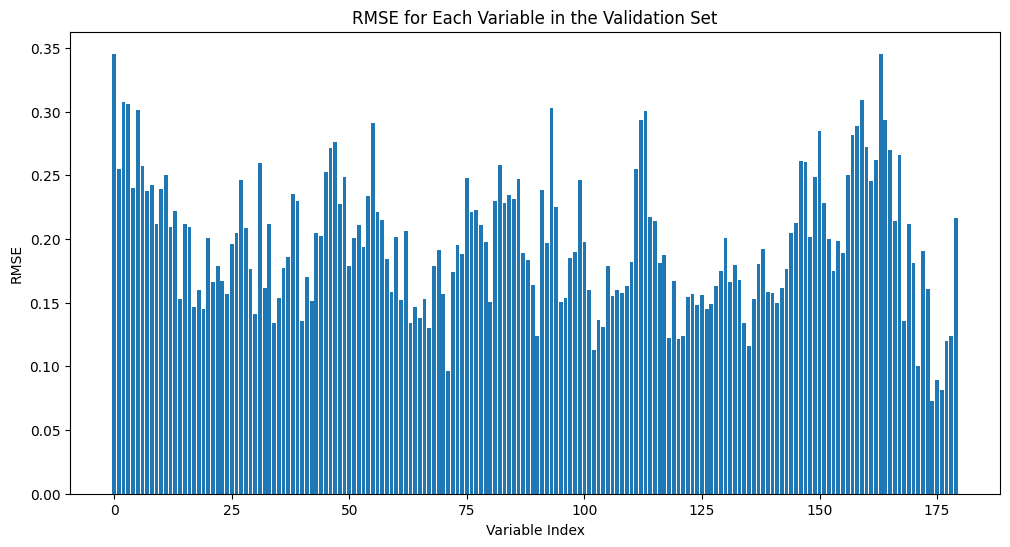

In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y')

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Define the validation date and split the data
DATE_VALIDATE = datetime.strptime('31/01/2010', '%d/%m/%Y')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Check the prepared datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check the results after applying PCA and Yule-Walker estimation
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Fit the ElasticNet model with cross-validation
data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Check the results after fitting ElasticNet with cross-validation
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)

# Validation Data
data_validate = model.std_data[:, int(model.std_data.shape[1] * 0.8):].T
fac_validate = model.factors.T[int(model.factors.shape[1] * 0.8):, :]

# Predict using the model
y_hat_validate = model.enet_predict(fac_validate)

# Compute RMSE for validation data
rmse_value = RMSE(data_validate, y_hat_validate)

# Check RMSE value
print(f"RMSE: {rmse_value}")

# RMSE waarden plotten
plt.figure(figsize=(12, 6))
plt.bar(range(len(rmse_value)), rmse_value)
plt.xlabel('Variable Index')
plt.ylabel('RMSE')
plt.title('RMSE for Each Variable in the Validation Set')
plt.show()

## Versie 12: Woensdag 13:13

Standardized data shape: (66, 347)
DATE_VALIDATE: 2010-01
((66, 180), (54, 180), (66, 169), (54, 180), (66, 169))
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (180, 9)
RMSE: [0.34540093 0.25503345 0.30784261 0.30565958 0.23967187 0.30148706
 0.2574635  0.23799561 0.24229224 0.21184805 0.2395499  0.25038898
 0.20970424 0.22180457 0.15270446 0.21198822 0.20914793 0.14661331
 0.16021209 0.14500789 0.20079238 0.16623088 0.17889684 0.16676639
 0.15696864 0.19615548 0.20479252 0.24594497 0.20859949 0.17645157
 0.14118905 0.25968953 0.16137724 0.21210136 0.13436814 0.15384759
 0.17726176 0.18577161 0.23552222 0.23003837 0.13582258 0.17038916
 0.15141175 0.20457154 0.2021699  0.25285294 0.27132298 0.27583883
 0.22778871 0.2489437  0.17845143 0.20094289 0.21110068 0.1938872
 0.23349201 0.29098672 0.22088326 0.21526476 0.18435644 0.15868665
 0.20141707 0.15246414 0.20647296 0.13419565 0.14623452 0.13790227
 0.15323414 0.1302494  0.17851331 0.1912441

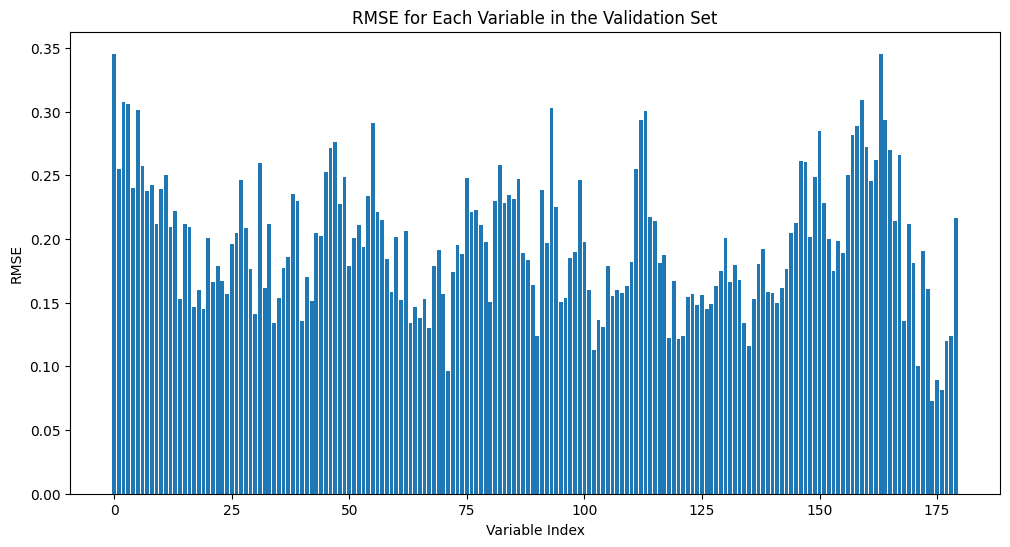

In [61]:


import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("Future date must be greater than the current data's last date.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)
    
# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Define the validation date and split the data
DATE_VALIDATE = pd.Period('2010-01', freq='M')
print("DATE_VALIDATE:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Date {DATE_VALIDATE} not found in dataframe columns")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Check the prepared datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Apply PCA and Yule-Walker estimation on the standardized data
model.std_data = Y_train_other_std.T  # Ensure the same data subset is used for PCA
model.apply_pca()
model.yw_estimation()

# Check the results after applying PCA and Yule-Walker estimation
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Fit the ElasticNet model with cross-validation
data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Check the results after fitting ElasticNet with cross-validation
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)

# Validation Data
data_validate = model.std_data[:, int(model.std_data.shape[1] * 0.8):].T
fac_validate = model.factors.T[int(model.factors.shape[1] * 0.8):, :]

# Predict using the model
y_hat_validate = model.enet_predict(fac_validate)

# Compute RMSE for validation data
rmse_value = RMSE(data_validate, y_hat_validate)

# Check RMSE value
print(f"RMSE: {rmse_value}")

# RMSE waarden plotten
plt.figure(figsize=(12, 6))
plt.bar(range(len(rmse_value)), rmse_value)
plt.xlabel('Variable Index')
plt.ylabel('RMSE')
plt.title('RMSE for Each Variable in the Validation Set')
plt.show()

In [72]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Utilities from utils.py
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Shape of X before any operation:", X.shape)
        print("Shape of Y before any operation:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Shape mismatch in number of columns: adjusting Y")
            Y = Y[:, :X.shape[1]]
            print("New shape of Y after adjustment:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Shape mismatch in number of rows: adjusting Y")
            Y = Y[:X.shape[0], :]
            print("New shape of Y after adjustment:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Transposed Shape of X:", X.T.shape)
        print("Transposed Shape of Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of rows in X and Y must be the same after transposing")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_period, scenarios=100):
        current_period = self.df_data.columns[-1]
        if future_period <= current_period:
            raise ValueError("Future period must be greater than the current data's last period.")
        num_months = (future_period.year - current_period.year) * 12 + future_period.month - current_period.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Function to calculate RMSE for expanding window
def calculate_expanding_window_rmse(model, start_date, end_date, prediction_date):
    prediction_period = pd.Period(prediction_date, freq='M')
    start_period = pd.Period(start_date, freq='M')
    end_period = pd.Period(end_date, freq='M')

    if prediction_period not in df_data.columns:
        raise ValueError(f"Prediction date {prediction_period} not found in dataframe columns")
    
    rmse_values = []
    current_period = start_period

    while current_period <= end_period:
        print(f"Training up to: {current_period}")
        date_index = df_data.columns.get_loc(current_period)
        if date_index < 12:  # Ensure at least 12 months of data for initial training
            current_period += 1
            continue

        Y_train_PCA = df_data.iloc[:, :date_index]

        REGRESSION_STEP = 12
        Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
        Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

        Y_train_other_std = standardize(Y_train_other.values.T).T
        Y_reg_train_std = standardize(Y_reg_train.values.T).T

        model.std_data = Y_train_other_std.T
        model.apply_pca()
        model.yw_estimation()

        data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
        fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

        model.enet_fit(data_train, fac_train)

        # Predict factors up to the prediction date
        forecast_factors = model.factor_forecast(prediction_period)
        
        # Predict CPI_Australia for the prediction date
        y_hat_predict = model.enet_predict(forecast_factors.T)
        cpi_actual = df_data.loc['CPI_Australia', prediction_period]

        # Ensure y_hat_predict has the correct dimensions
        if len(y_hat_predict) == 0 or len(y_hat_predict.shape) == 1:
            print(f"Skipping prediction for {current_period}, due to mismatched prediction dimensions.")
            current_period += 1
            continue

        rmse = np.sqrt(np.mean((y_hat_predict[0] - cpi_actual) ** 2))
        rmse_values.append(rmse)

        current_period += 1

    return rmse_values

# Calculate RMSE using expanding window
rmse_values = calculate_expanding_window_rmse(model, '1995-01', '2010-01', '2023-11')
print(rmse_values)


Standardized data shape: (66, 347)
Training up to: 1995-01
Training up to: 1995-02
Training up to: 1995-03
Training up to: 1995-04
Training up to: 1995-05
Training up to: 1995-06
Training up to: 1995-07
Training up to: 1995-08
Training up to: 1995-09
Training up to: 1995-10
Training up to: 1995-11
Training up to: 1995-12
Training up to: 1996-01
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (12, 9)


ValueError: Future period must be greater than the current data's last period.

## Versie 13: Woensdag 14:35

In [76]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# Utilities for data preprocessing and evaluation
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat

def expanding_window_forecast(model, df_data, start_date, end_date, prediction_date):
    start_period = pd.Period(start_date, freq='M')
    end_period = pd.Period(end_date, freq='M')
    prediction_period = pd.Period(prediction_date, freq='M')

    if prediction_period not in df_data.columns:
        raise ValueError(f"Prediction date {prediction_period} not found in dataframe columns")

    rmse_values = []
    current_period = start_period

    while current_period <= end_period:
        print(f"Training up to: {current_period}")
        date_index = df_data.columns.get_loc(current_period)
        if date_index < 12:  # Ensure at least 12 months of data for initial training
            current_period += 1
            continue

        # Prepare training data
        Y_train_PCA = df_data.iloc[:, :date_index + 1]

        REGRESSION_STEP = 12
        Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
        Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

        Y_train_other_std = standardize(Y_train_other.values.T).T
        Y_reg_train_std = standardize(Y_reg_train.values.T).T

        model.std_data = Y_train_other_std.T
        model.apply_pca()
        model.yw_estimation()

        data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
        fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

        model.enet_fit(data_train, fac_train)

        # Predict factors up to the prediction date
        forecast_factors = model.factor_forecast(prediction_period)
        
        # Predict CPI_Australia for the prediction date
        y_hat_predict = model.enet_predict(forecast_factors.T)
        cpi_actual = df_data.loc['CPI_Australia', prediction_period]

        if y_hat_predict.shape[0] > 0 and len(cpi_actual) > 0:
            rmse = RMSE(cpi_actual, y_hat_predict[0])
            rmse_values.append(rmse)

        current_period += 1

    return rmse_values

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Calculate RMSE using expanding window
rmse_values = expanding_window_forecast(model, '1995-01', '2010-01', '2023-01')
print(rmse_values)

# Plot the RMSE values
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o')
plt.xlabel('Expanding Window Step')
plt.ylabel('RMSE')
plt.title('RMSE for Expanding Window Forecast')
plt.grid(True)
plt.show()


Standardized data shape: (66, 347)


TypeError: expanding_window_forecast() missing 1 required positional argument: 'prediction_date'

In [74]:
print(df_data.columns[:-5])

PeriodIndex(['1995-01', '1995-02', '1995-03', '1995-04', '1995-05', '1995-06',
             '1995-07', '1995-08', '1995-09', '1995-10',
             ...
             '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
             '2023-03', '2023-04', '2023-05', '2023-06'],
            dtype='period[M]', length=342)


## Versie 14: Woensdag 15:07

Even zonder expanding window, gewoon trainen tot 2010, dan nov 2023 voorspellen

In [81]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# Utilities for data preprocessing and evaluation
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Standardized data shape:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factors shape:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker estimation shape:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix shape:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def factor_forecast(self, future_period, scenarios=100):
        current_period = self.df_data.columns[-1]
        print(f"Current period: {current_period}, Future period: {future_period}")
        if future_period <= current_period:
            raise ValueError("Future period must be greater than the current data's last period.")
        num_months = (future_period.year - current_period.year) * 12 + future_period.month - current_period.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)

# Load and preprocess data
df_data = pd.read_excel("C:/Thesis/03. Data/Final version data/Static.xlsx", engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Print the shape of the DataFrame
print(f"DataFrame shape: {df_data.shape}")

# Print the first 5 columns and the last 5 columns to verify
print("First 5 columns of the DataFrame:")
print(df_data.columns[:5])
print("Last 5 columns of the DataFrame:")
print(df_data.columns[-5:])

# Initialize the model
model = DynamicFactorModel(df_data, num_factors=9)

# Train the model on data from 1995 to 2020
DATE_TRAIN_END = pd.Period('2020-01', freq='M')
if DATE_TRAIN_END not in df_data.columns:
    raise ValueError(f"Training end date {DATE_TRAIN_END} not found in dataframe columns")

date_index = df_data.columns.get_loc(DATE_TRAIN_END)
Y_train_PCA = df_data.iloc[:, :date_index + 1]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

model.std_data = Y_train_other_std.T
model.apply_pca()
model.yw_estimation()

# Use all data up to DATE_TRAIN_END for training
data_train = model.std_data.T
fac_train = model.factors.T

model.enet_fit(data_train, fac_train)

# Predict for November 2023
PREDICTION_DATE = '2023-11'
prediction_period = pd.Period(PREDICTION_DATE, freq='M')
forecast_factors = model.factor_forecast(prediction_period)

# Predict CPI_Australia for the prediction date
y_hat_predict = model.enet_predict(forecast_factors.T)
cpi_actual = df_data.loc['CPI_Australia', prediction_period]

# Ensure y_hat_predict has the correct dimensions and calculate RMSE
if y_hat_predict.shape[0] > 0 and len(cpi_actual) > 0:
    rmse = RMSE(cpi_actual, y_hat_predict[0])
    print(f"RMSE for CPI_Australia on {PREDICTION_DATE}: {rmse}")
else:
    print(f"Prediction dimensions mismatch or missing actual data for {PREDICTION_DATE}")


DataFrame shape: (66, 347)
First 5 columns of the DataFrame:
PeriodIndex(['1995-01', '1995-02', '1995-03', '1995-04', '1995-05'], dtype='period[M]')
Last 5 columns of the DataFrame:
PeriodIndex(['2023-07', '2023-08', '2023-09', '2023-10', '2023-11'], dtype='period[M]')
Standardized data shape: (66, 347)
PCA factors shape: (9, 54)
Yule-Walker estimation shape: (10, 9)
ElasticNet B_matrix shape: (301, 9)
Current period: 2023-11, Future period: 2023-11


ValueError: Future period must be greater than the current data's last period.

## Versie 15: Woensdag 15:35

We gaan weer verder met versie 12.

Gestandaardiseerde data vorm: (66, 347)
VALIDATIEDATUM: 2010-01
((66, 180), (54, 180), (66, 169), (54, 180), (66, 169))
PCA factoren vorm: (9, 54)
Yule-Walker schatting vorm: (10, 9)
ElasticNet B_matrix vorm: (180, 9)
RMSE: [0.34540093 0.25503345 0.30784261 0.30565958 0.23967187 0.30148706
 0.2574635  0.23799561 0.24229224 0.21184805 0.2395499  0.25038898
 0.20970424 0.22180457 0.15270446 0.21198822 0.20914793 0.14661331
 0.16021209 0.14500789 0.20079238 0.16623088 0.17889684 0.16676639
 0.15696864 0.19615548 0.20479252 0.24594497 0.20859949 0.17645157
 0.14118905 0.25968953 0.16137724 0.21210136 0.13436814 0.15384759
 0.17726176 0.18577161 0.23552222 0.23003837 0.13582258 0.17038916
 0.15141175 0.20457154 0.2021699  0.25285294 0.27132298 0.27583883
 0.22778871 0.2489437  0.17845143 0.20094289 0.21110068 0.1938872
 0.23349201 0.29098672 0.22088326 0.21526476 0.18435644 0.15868665
 0.20141707 0.15246414 0.20647296 0.13419565 0.14623452 0.13790227
 0.15323414 0.1302494  0.17851331 0.1912

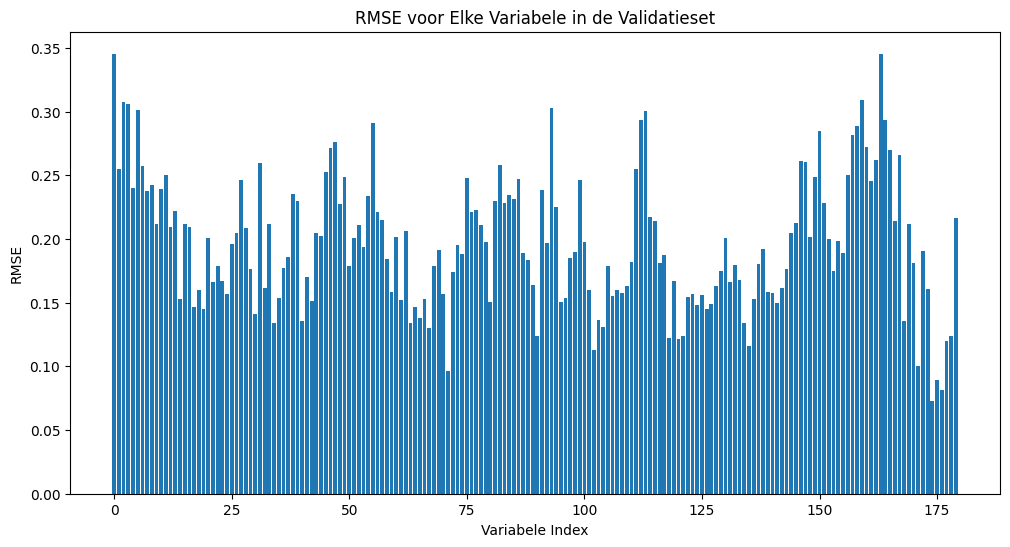

In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import MultiTaskElasticNetCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import statsmodels.api as sm
from datetime import datetime

# Functies voor standaardisatie en RMSE berekening
def standardize(variables):
    central = (variables - variables.mean())
    return central / central.std()

def RMSE(data: pd.DataFrame, estimation: pd.DataFrame):
    df_errors = (estimation - data)
    df_rmse = ((df_errors) ** 2.0).mean(axis=0) ** 0.5
    return df_rmse

# Dynamic Factor Model klasse
class DynamicFactorModel:
    def __init__(self, df_data, num_factors):
        self.df_data = df_data
        self.num_factors = num_factors
        self.std_data = standardize(df_data.values.T).T
        print("Gestandaardiseerde data vorm:", self.std_data.shape)
        self.pca = PCA(n_components=num_factors)
        self.factors = None
        self.phi = None
        self.B_mat = None
        self.model_ena = None

    def apply_pca(self):
        self.factors = self.pca.fit_transform(self.std_data.T).T
        print("PCA factoren vorm:", self.factors.shape)

    def yw_estimation(self):
        model = sm.tsa.VAR(self.factors.T)
        results = model.fit(1)
        self.phi = results.params
        print("Yule-Walker schatting vorm:", self.phi.shape)

    def enet_fit(self, data_train, fac_train):
        self.model_ena = MultiTaskElasticNetCV(cv=5)
        self.model_ena.fit(fac_train, data_train)
        self.B_mat = self.model_ena.coef_
        x_hat = self.model_ena.predict(fac_train)
        intercept = self.model_ena.intercept_
        r2_insample = r2_score(data_train, x_hat)
        print("ElasticNet B_matrix vorm:", self.B_mat.shape)
        return self.B_mat, r2_insample, intercept

    def enet_predict(self, fac_predict):
        x_hat = self.model_ena.predict(fac_predict)
        return x_hat
    
    def autoregression(self, data_train_reg, fac_train, beta_const):
        X = data_train_reg.T
        Y = (self.std_data.T - np.dot(fac_train, self.B_mat.T) - beta_const).T

        print("Vorm van X voor enige operatie:", X.shape)
        print("Vorm van Y voor enige operatie:", Y.shape)

        if X.shape[1] != Y.shape[1]:
            print("Vorm mismatch in aantal kolommen: aanpassen van Y")
            Y = Y[:, :X.shape[1]]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        if X.shape[0] != Y.shape[0]:
            print("Vorm mismatch in aantal rijen: aanpassen van Y")
            Y = Y[:X.shape[0], :]
            print("Nieuwe vorm van Y na aanpassing:", Y.shape)

        Y = np.matrix(Y)
        X = np.matrix(X)

        print("Getransponeerde vorm van X:", X.T.shape)
        print("Getransponeerde vorm van Y:", Y.T.shape)

        if X.shape[0] != Y.shape[0]:
            raise ValueError("Het aantal rijen in X en Y moet gelijk zijn na transponeren")

        model = sm.OLS(Y, X)
        results = model.fit()
        return results.params

    def dfm_fit_pcayw(self, data_train, data_train_reg):
        self.apply_pca()
        self.yw_estimation()
        self.B_mat, r2_insample, beta_const = self.enet_fit(data_train, self.factors.T)
        C_matrix = self.autoregression(data_train_reg, self.factors.T, beta_const)
        return self.B_mat, C_matrix, r2_insample, beta_const

    def factor_forecast(self, future_date, scenarios=100):
        future_date = datetime.strptime(future_date, '%d/%m/%Y')
        current_date = self.df_data.columns[-1]
        if future_date <= current_date:
            raise ValueError("De toekomstige datum moet later zijn dan de laatste datum in de data.")
        num_months = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month
        
        phi = self.phi[1:].T
        intercept = self.phi[0]
        factors_forecast = []
        factors = self.factors.T[-1]
        
        for _ in range(num_months):
            factors = np.dot(phi, factors) + intercept
            factors_forecast.append(factors)
        
        return np.array(factors_forecast)
    
# Data inladen en voorbewerken
file_path = 'C:/Thesis/03. Data/Final version data/Static.xlsx'
df_data = pd.read_excel(file_path, engine='openpyxl', index_col=0)
df_data.columns = pd.to_datetime(df_data.columns, format='%d/%m/%Y').to_period('M')

# Initialiseer het model
model = DynamicFactorModel(df_data, num_factors=9)

# Bepaal de validatiedatum en splits de data
DATE_VALIDATE = pd.Period('2010-01', freq='M')
print("VALIDATIEDATUM:", DATE_VALIDATE)

if DATE_VALIDATE in df_data.columns:
    date_index = df_data.columns.get_loc(DATE_VALIDATE)
else:
    raise ValueError(f"Datum {DATE_VALIDATE} niet gevonden in de kolommen van de dataframe")

Y_train_PCA = df_data.iloc[:, :date_index]

REGRESSION_STEP = 12
Y_train_other = Y_train_PCA.iloc[REGRESSION_STEP:, :]
Y_reg_train = df_data.iloc[:, :date_index + 1 - REGRESSION_STEP]

Y_train_other_std = standardize(Y_train_other.values.T).T
Y_reg_train_std = standardize(Y_reg_train.values.T).T

# Controleer de voorbereide datasets
print((Y_train_PCA.shape, Y_train_other.shape, Y_reg_train.shape, 
 Y_train_other_std.shape, Y_reg_train_std.shape))

# Voer PCA en Yule-Walker schatting uit op de gestandaardiseerde data
model.std_data = Y_train_other_std.T  # Zorg ervoor dat dezelfde subset data wordt gebruikt voor PCA
model.apply_pca()
model.yw_estimation()

# Controleer de resultaten na het toepassen van PCA en Yule-Walker schatting
pca_factors_shape = model.factors.shape
yw_estimation_shape = model.phi.shape

# Pas het ElasticNet-model aan met cross-validatie
data_train = model.std_data[:, :int(model.std_data.shape[1] * 0.8)].T
fac_train = model.factors.T[:int(model.factors.shape[1] * 0.8), :]

B_matrix, r2_insample, intercept = model.enet_fit(data_train, fac_train)

# Controleer de resultaten na het aanpassen van ElasticNet met cross-validatie
B_matrix_shape = B_matrix.shape
r2_insample_value = r2_insample
intercept_value = intercept

(pca_factors_shape, yw_estimation_shape, B_matrix_shape, r2_insample_value, intercept_value)

# Validatie Data
data_validate = model.std_data[:, int(model.std_data.shape[1] * 0.8):].T
fac_validate = model.factors.T[int(model.factors.shape[1] * 0.8):, :]

# Voorspel met het model
y_hat_validate = model.enet_predict(fac_validate)

# Bereken RMSE voor validatie data
rmse_value = RMSE(data_validate, y_hat_validate)

# Controleer de RMSE waarde
print(f"RMSE: {rmse_value}")

# Plot RMSE waarden
plt.figure(figsize=(12, 6))
plt.bar(range(len(rmse_value)), rmse_value)
plt.xlabel('Variabele Index')
plt.ylabel('RMSE')
plt.title('RMSE voor Elke Variabele in de Validatieset')
plt.show()
